In [1]:
# required library imports
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [2]:
# loading vgg19 model

model = VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 2s 0us/step


In [3]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = cv.imread(image_path)
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img=cv.resize(img,(224,224))
    # img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img)

def preprocess_image2(image):
    # image=image.numpy()
    img=cv.cvtColor(image,cv.COLOR_BGR2RGB)
    img=cv.resize(img,(224,224))
    # img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img)

In [8]:
base_path="/content/WhatsApp Image 2024-06-18 at 8.12.15 PM.jpeg"
style_path="/content/download.jpeg"

In [9]:
base_=cv.imread(base_path)
base_=cv.cvtColor(base_,cv.COLOR_BGR2RGB)
style_=cv.imread(style_path)
style_=cv.cvtColor(style_,cv.COLOR_BGR2RGB)

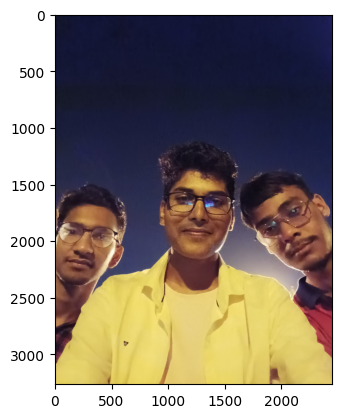

In [10]:
plt.imshow(base_)

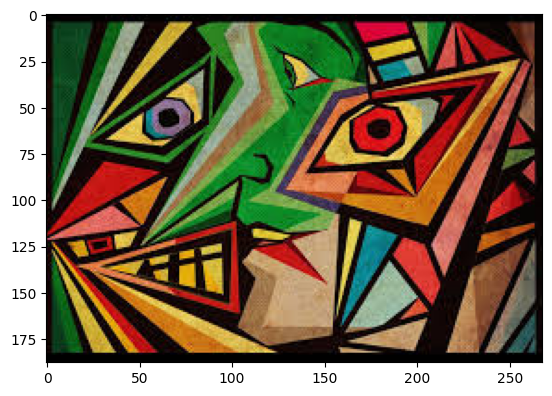

In [11]:
plt.imshow(style_)

In [60]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x[0]
    # Remove zero-center by mean pixel

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'
    x = cv.cvtColor(x,cv.COLOR_BGR2RGB)
    x = np.clip(x, 0, 255).astype("uint8")
    x=cv.resize(x,(base_.shape[1]//(min(base_image.shape[1]//224 +1,4)),base_.shape[0]//(min(base_image.shape[0]//224 +1,4))),interpolation=cv.INTER_CUBIC)
    # print(x.shape)
    return x

In [61]:
img_nrows=224
img_ncols=224

In [62]:
def gram_matrix(x):

    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * ((combination.shape[-1])**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))/1000


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [63]:
style_layer_names = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv3",
    "block4_conv2",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv3"


def compute_loss(combination_image, base_image, style_reference_image):

    input_tensor = tf.concat(
        [base_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    # print('yes')
    # Initialize the loss
    closs = tf.zeros(shape=())
    sloss = tf.zeros(shape=())
    loss = tf.zeros(shape=())
    # print(loss)

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[1, :, :, :]
    closs=closs+content_loss(base_image_features, combination_features)
    loss = loss +   content_loss(base_image_features, combination_features)

    fn,fm=style_reference_image.shape[0]//224 +1,style_reference_image.shape[1]//224 +1
    fn=min(4,fn)
    fm=min(4,fm)
    n,m=style_reference_image.shape[0]//fn,style_reference_image.shape[1]//fm

    # Add style loss
    for i in range(fn):
     for j in range(fm):
      s_img_slice = style_reference_image[i*n:(i+1)*n,j*m:(j+1)*m]

      s_img=tf.Variable( tf.convert_to_tensor(preprocess_image2((s_img_slice))))
      feature_s = feature_extractor(s_img)
      for layer_name in style_layer_names:
        layer_feature_s = feature_s[layer_name]
        layer_feature_c= features[layer_name]
        style_reference_features = layer_feature_s[0, :, :, :]
        combination_features = layer_feature_c[1, :, :, :]
        sl = style_loss(style_reference_features, combination_features)/10
        sloss= sloss+(1 / len(style_layer_names)) * sl
        loss += (1 / len(style_layer_names)) * sl
        # print(sl)
    # print('yes')

    # Add total variation loss
    loss +=  1e-7*total_variation_loss(combination_image)
    # print(total_variation_loss(combination_image))

    return loss,closs,sloss

In [64]:
result_prefix='output'

In [65]:

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    # print(type(style_reference_image))
    with tf.GradientTape() as tape:
        loss,closs,sloss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)

    return loss, grads,closs,sloss

In [66]:
def apply_avg_pooling(image, pool_size=2, strides=2):
    return tf.nn.avg_pool2d(image, ksize=pool_size, strides=strides, padding='SAME')

def upsample_image(image, original_size):
    return tf.image.resize(image, size=original_size, method=tf.image.ResizeMethod.BILINEAR)

In [ ]:

base_image=cv.imread(base_path)
style_image=cv.imread(style_path)
# base_image =tf.Variable( tf.convert_to_tensor(preprocess_image(base_path)))
# style_reference_image = tf.Variable( tf.convert_to_tensor(preprocess_image(style_path)))
fn,fm=base_image.shape[0]//224 +1,base_image.shape[1]//224 +1
fn=min(4,fn)
fm=min(4,fm)
n,m=base_image.shape[0]//fn,base_image.shape[1]//fm


for i in range(fn):
  for j in range(fm):
    optimizer = tf.keras.optimizers.legacy.Adam(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=10.0, decay_steps=10, decay_rate=0.99
    )
    )
    combination_image=tf.Variable( tf.convert_to_tensor(preprocess_image2(np.array(base_image[i*n:(i+1)*n,j*m:(j+1)*m]))))
    base=tf.Variable( tf.convert_to_tensor(preprocess_image2(np.array(base_image[i*n:(i+1)*n,j*m:(j+1)*m]))))
    original_size = tf.shape(combination_image)[1:3]
    iterations = 100
    for k in range(1, iterations + 1):
        # print(type(style_image))
        loss,grads,closs,sloss = compute_loss_and_grads(
        combination_image, base, style_image
        )

        optimizer.apply_gradients([(grads, combination_image)])




        if True:
            print("Iteration %d: loss=%.2f" % (k, loss),"content loss=%.2f" % (closs),"style loss=%.2f" % (sloss))

        # print(grads)
            if(k%51==0):
              pooled_image = apply_avg_pooling(combination_image)
              combination_image.assign(upsample_image(pooled_image, original_size))

            if  k%1==0:

                img1 = deprocess_image(combination_image.numpy())
                # print(img1.shape)
                base_image[i*n:(i+1)*n,j*m:(j+1)*m,:]=img1
                fname = result_prefix + "_at_iteration_%d.png" % (i*100 +j*10 +k)
                keras.utils.save_img(fname, img1)


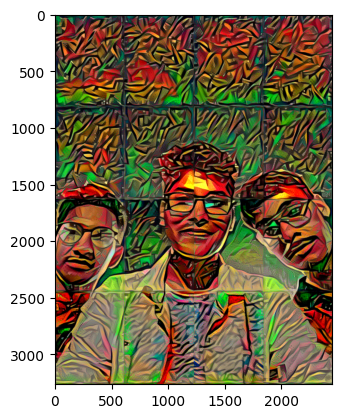

In [68]:
plt.imshow(base_image)

In [69]:
fname = result_prefix +'.png'
keras.utils.save_img(fname, base_image)